# **Ensemble for Cardovascular Disease (CVD) Detection**

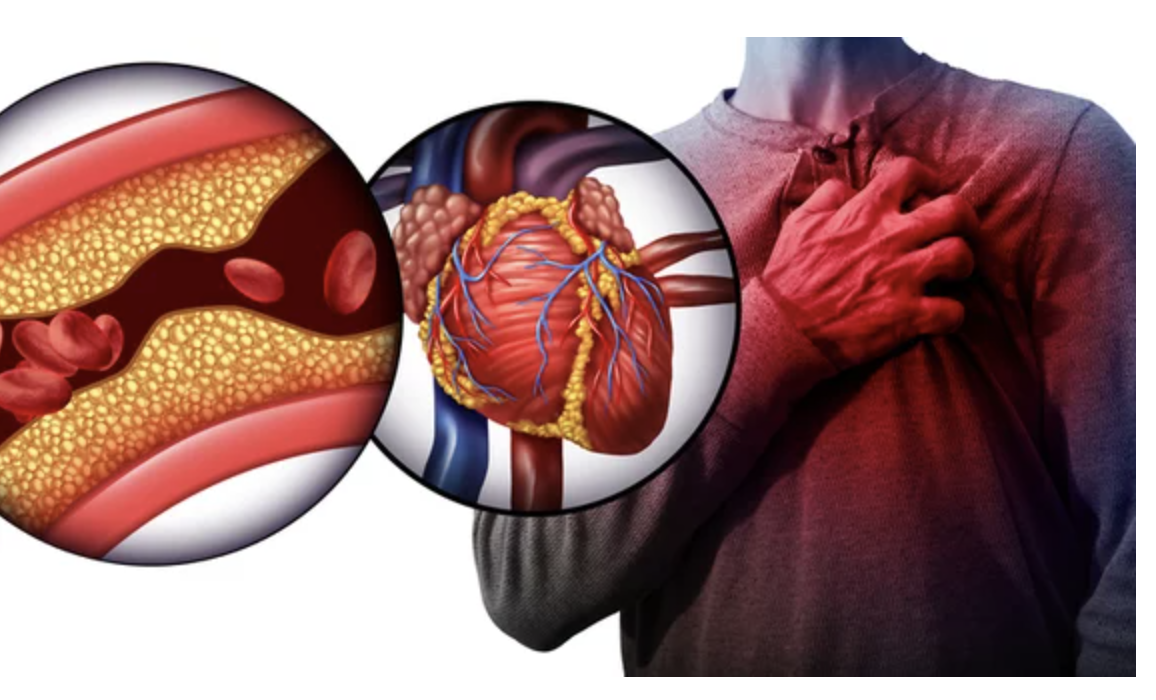

Cardiovascular disease (CVD) is a broad term encompassing various conditions affecting the heart and blood vessels, including coronary artery disease, heart attacks, stroke, and hypertension. It remains the leading cause of death worldwide, accounting for approximately 17.9 million deaths annually, according to the World Health Organization (WHO). Many risk factors contribute to CVD, including lifestyle choices (smoking, poor diet, lack of exercise), genetic predisposition, and underlying medical conditions like diabetes and high blood pressure.

Despite advances in medical science, early detection remains a significant challenge. Traditional diagnostic methods, such as electrocardiograms (ECGs), blood tests, and imaging techniques, often detect CVD at later stages when symptoms become apparent. However, preventive care and early intervention are critical in reducing morbidity and mortality rates.

With the emergence of big data in healthcare, predictive analytics using machine learning (ML) and artificial intelligence (AI) has become a promising approach to identifying individuals at risk of developing CVD. By analyzing large-scale patient data, AI can detect hidden patterns and predict the likelihood of disease onset before traditional symptoms appear. This technology holds immense potential for preventive healthcare, improving patient outcomes while reducing the financial burden on healthcare systems.

---

The dataset consists of three types of input features—Objective, Examination, and Subjective—which provide comprehensive patient information. These features help in predicting the presence or absence of cardiovascular disease (CVD) as a binary target variable (cardio: 0 = No CVD, 1 = CVD present).

---

The list of features are as follows:

1) Age

2) Height

3) Weight

4) Gender

5) Systolic blood pressure

6) Diastolic blood pressure

7) Cholesterol

8) Glucose

9) Smoking

10) Alcohol intake

11) Physical activity

12) Presence or absence of cardiovascular disease

---

# **Question 1**

Using Python coding, read the file. Present number of the samples, number of the samples for each class, type of features.

In [ ]:
pip install boruta

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Core Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# Preprocessing & Utilities

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Imbalance Handling

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Feature Selection

from boruta import BorutaPy

# Models: Base & Ensemble

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Model Evaluation

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# Calibration

from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay

# Future Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


I aggregated all the import here for better readability and ease of use to understand what all libraries went behind the analysis and avoid redundancy.

Total number of samples: 70000

Class distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64 

Feature type counts:
int64      12
float64     1
Name: count, dtype: int64 


Detailed Feature Classification:
        Feature    Dtype  Unique Values Categorical/Discrete/Continuous
0            id    int64          70000                      Continuous
1           age    int64           8076                      Continuous
2        gender    int64              2                        Discrete
3        height    int64            109                      Continuous
4        weight  float64            287                      Continuous
5         ap_hi    int64            153                      Continuous
6         ap_lo    int64            157                      Continuous
7   cholesterol    int64              3                        Discrete
8          gluc    int64              3                        Discrete
9         smoke    int64              2                     

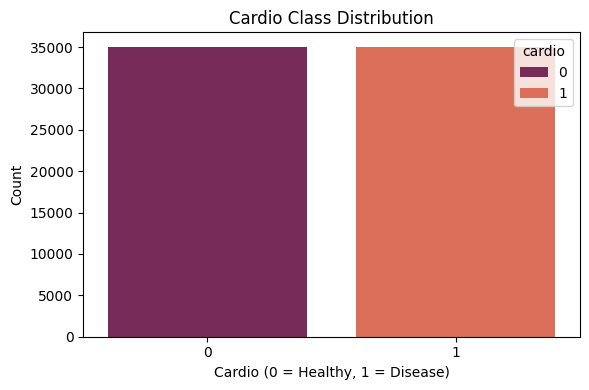

In [ ]:
# Loading the dataset
df = pd.read_csv("cardio_Heart.csv", sep=";")

# Total number of samples
total_samples = df.shape[0]

# Number of samples per class (Assuming target column is 'cardio')
class_distribution = df['cardio'].value_counts()

# Feature types
feature_types = df.dtypes.value_counts()

# Detailed list of types by column
detailed_types = df.dtypes

# Function to classify feature types
def classify_feature(col, dtype, unique_vals, n_samples):
    if dtype == 'object':
        return "Categorical"
    elif dtype in ['int64', 'float64']:
        if unique_vals < 5:
            return "Discrete"
        else:
            return "Continuous"
    else:
        return "Other"

# Building a summary dataframe
feature_summary = []
for col in df.columns:
    dtype = df[col].dtype
    unique_vals = df[col].nunique()
    feature_type = classify_feature(col, dtype, unique_vals, df.shape[0])
    feature_summary.append([col, dtype, unique_vals, feature_type])

feature_summary_df = pd.DataFrame(feature_summary, columns=["Feature", "Dtype", "Unique Values", "Categorical/Discrete/Continuous"])


# Output all results
print(f"Total number of samples: {total_samples}\n")
print("Class distribution:")
print(class_distribution, "\n")
print("Feature type counts:")
print(feature_types, "\n")
print("\nDetailed Feature Classification:")
print(feature_summary_df)
print(df.head())
print(df.describe())

# Boxplot of cardio (though not very informative since it's binary)
plt.figure(figsize=(6,4))
sns.countplot(x='cardio', hue="cardio", data=df, palette='rocket')
plt.title('Cardio Class Distribution')
plt.xlabel('Cardio (0 = Healthy, 1 = Disease)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

For the initial step, upon checking number of samples it was seen we have 70000 samples, then I checked for class distribution for target class `cardio` and also visuallized it with plot in the end as well.
Here, we observed Class distribution for target `cardio` as follows:

- 0: 35021
- 1: 34979

It was observed that we have a total of 13 features, where `id` is not useful feature at all.In these 13 features it is observed that we have 5 Continous Features numely, **['age', 'height', 'weight', 'ap_hi', 'ap_lo']** (excluding id). The feature classification was done in the basis of unique values in the columns which was `<=5` unique values.

I have also printed the first 5 rows of the dataset and description of each feature to better understand the data I am dealing with.

# **Question 2**

The second step is data pre-processing, which is the goal  is to ensure that the dataset is structured, clean, and ready for effective analysis.

to understand the quality of the data, two investigations are needed.

1) Duplicated Removal and Missing Data Imputation


2) Outlier Removal

Provide possible solutions to these investigations, and briefly discuss the potential techniques.

In [ ]:
df_cleaned = df

# # Converting 'age' from days to years (integer)
# df_cleaned['age'] = (df_cleaned['age'] / 365).astype(int)

# Dropping 'id'
if 'id' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['id'])

print("'id' column dropped. New shape:", df_cleaned.shape)

'id' column dropped. New shape: (70000, 12)


I have made a copy of the Data Frame as `df_cleaned` so that the original dataset is not used rather a copy of it is used and we havethe flexibility to choose whether we want to use the original data frame in the future or not.

I was thinking of converting age to years but then I found upon converting it there where a lot of duplicate values as we where making them round up hence, it would increase the complexity instead of decreasing it. So I let it be.

Let's drop the id column and then check for duplicates so that we are sure that its not the id that keeps the rows unique instead of the actual data.

In [ ]:
# Identify duplicates
duplicates_count = df_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 24


I found 24 duplicate rows, whereas with `id` still on I had none, this shows how important it is to get rid of such columns early on to save on accuracy.

Though 24 is not a huge number, but if in case it would have been larger it would have hindered with the accuracy.

In [ ]:
# Handle duplicates by dropping them
df_cleaned = df_cleaned.drop_duplicates()
print(f"Shape after removing duplicates: {df_cleaned.shape}")
print(f"Remaining duplicates: {df_cleaned.duplicated().sum()}")

Shape after removing duplicates: (69976, 12)
Remaining duplicates: 0


As the reason for duplicate check stated there where 24 duplicate rows in the dataset. But, incase we where to extend the dataset and introduce new values that may or may not contain duplicate rows, `drop_duplicates()` makes the code future proof to duplicate values.

As seen the shape of the data is 70000 rows and 12 columns (features and label) after dropping `id`.

In [ ]:
# Identify missing values
missing_values = df_cleaned.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


Next, I checked for missing values in the `df_cleaned` dataframe. Which has already gone through cleaning of duplicates (if any).

But, I did not find any missing values in the data frame as well.

In [ ]:
# Handling missing values
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:
        if df_cleaned[col].dtype in ['int64', 'float64']:
            df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
        else:
            df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

print("Missing values after imputation:\n", df_cleaned.isnull().sum())

Missing values after imputation:
 age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


Even though I didn't find any missing values in the intial step I have introduced imputation of missing values.

The imputation is Median and Mode, where numerical values are dealt with using Median imputation and for others I have used Mode. For a more systematic and data type based data handling.

In [ ]:
# Identifying outliers using IQR method
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    return outliers, lower_bound, upper_bound

# Identifying continuous features (excluding categorical/ordinal ones with few unique values <=5)
continuous_features = [
    col for col in df_cleaned.select_dtypes(include=[np.number]).columns
    if df_cleaned[col].nunique() > 5
]

print("Continuous features considered for outlier detection:", continuous_features)

print("\nOutliers before removal (only continuous features):")
for col in continuous_features:
    outliers, lb, ub = detect_outliers_iqr(df_cleaned, col)
    if outliers > 0:
        print(f"{col}: {outliers} outliers (bounds: {lb:.2f}, {ub:.2f})")

Continuous features considered for outlier detection: ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

Outliers before removal (only continuous features):
age: 4 outliers (bounds: 12169.50, 26821.50)
height: 519 outliers (bounds: 142.50, 186.50)
weight: 1819 outliers (bounds: 39.50, 107.50)
ap_hi: 1435 outliers (bounds: 90.00, 170.00)
ap_lo: 4632 outliers (bounds: 65.00, 105.00)


In this step, I have checked for outliers using Interquartile Range technique. This helps us identify extreme values that may affect the performance of the model. I have also made sure we focus on the Continous features for Outlier detection where the unique values are less than 5, so that we donot detect outliers in Discrete features which may have values such as 0,1 or 1,2,3 etc which to an extent are categorical in a way for example, active 0,1 states if a person is active yes or no etc.

The highest number of outliers where observed in `ap_lo` (Diastolic blood pressure) feature **(4632)** **~0.06%** followed by `weight` with **(1819)** **~0.02%**, and  `ap_hi` (Systolic blood pressure) feature **(1435)** **~0.02%**.

In [ ]:
# Counting For Distribution of Unique Values for Glucose and Cholestrol
print("Glucose distribution:")
print(df_cleaned['gluc'].value_counts())

print("\nCholesterol distribution:")
print(df_cleaned['cholesterol'].value_counts())

Glucose distribution:
gluc
1    59455
3     5331
2     5190
Name: count, dtype: int64

Cholesterol distribution:
cholesterol
1    52361
2     9549
3     8066
Name: count, dtype: int64


Just tried to make sure that the Features with 3 unique values, i.e. Glucose and Cholestrol have the other values in a good number for them to exist and are not some minimal outliers.

In [ ]:
# # Handling Outliers by Removing them (IQR Method)

# # Working on a copy so we don't affect df_cleaned directly
# df_no_outliers = df_cleaned.copy()

# for col in continuous_features:
#     Q1 = df_no_outliers[col].quantile(0.25)
#     Q3 = df_no_outliers[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Keeping only rows within the bounds
#     df_no_outliers = df_no_outliers[
#         (df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)
#     ]

# print(f"Shape after removing outliers: {df_no_outliers.shape}")

# # Re-checking outliers after removal
# print("\nOutliers after removal:")
# for col in continuous_features:
#     outliers, lb, ub = detect_outliers_iqr(df_no_outliers, col)
#     if outliers > 0:
#         print(f"{col}: {outliers} outliers remain with the lower bound {lower_bound} and upper bound {upper_bound}")
#     else:
#         print(f"{col}: no outliers")

As observed while going through the removing outliers process, where we ignore the columns with less than 5 unique values as per our analysis earlier, this step was taken in order to avoid capping values that represent actual categories rather than being outliers.

In this process we lost a lot of data almost ~11% (10.7%). So as an alternative to keeping the amount of data intact. I have implemented capping.

In [ ]:
for col in continuous_features:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound,
                        np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col]))

print("\nOutlier capping applied to continuous features only.")

# Re-checking outliers after capping
print("\nOutliers after capping:")
for col in continuous_features:
    outliers, lb, ub = detect_outliers_iqr(df_cleaned, col)
    print(f"{col}: {outliers} outliers remaining")


Outlier capping applied to continuous features only.

Outliers after capping:
age: 0 outliers remaining
height: 0 outliers remaining
weight: 0 outliers remaining
ap_hi: 0 outliers remaining
ap_lo: 0 outliers remaining


Here, as an alternative to **Removing Data** we have performed capping so that the data set remains intact and we can have more data to train out model on. For capping I have made sure to cap the continous values only.

In this process I have handled the outliers in the following way:-

- Any value below the lower bound with the lower bound itself.
- Any value above the upper bound with the upper bound itself.
- Values within the bounds are left unchanged.

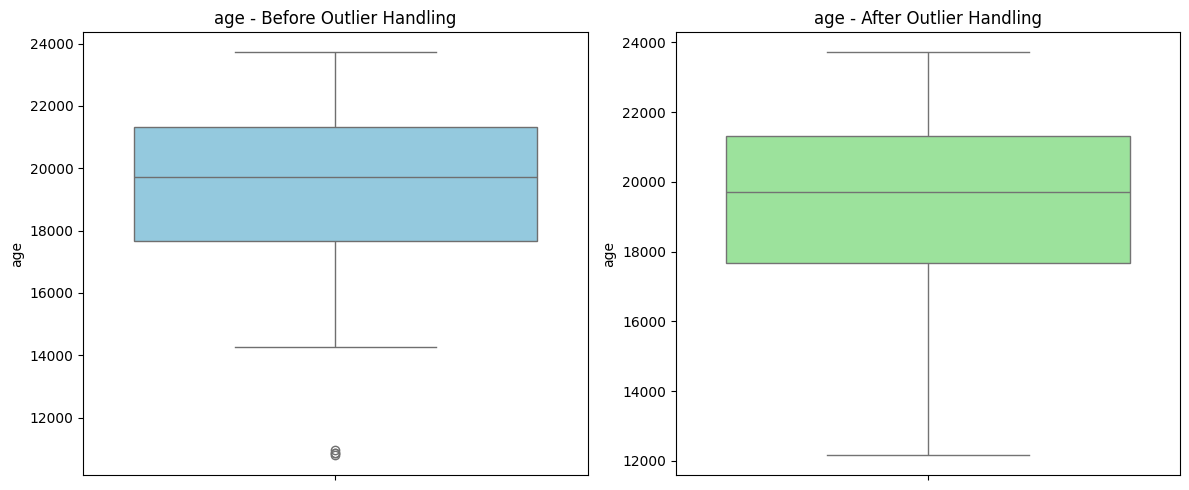

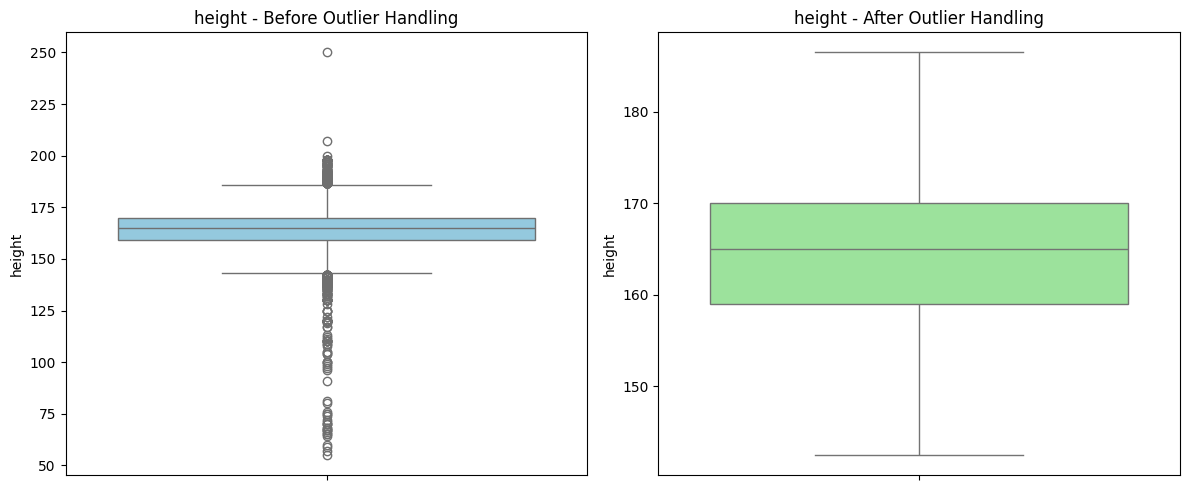

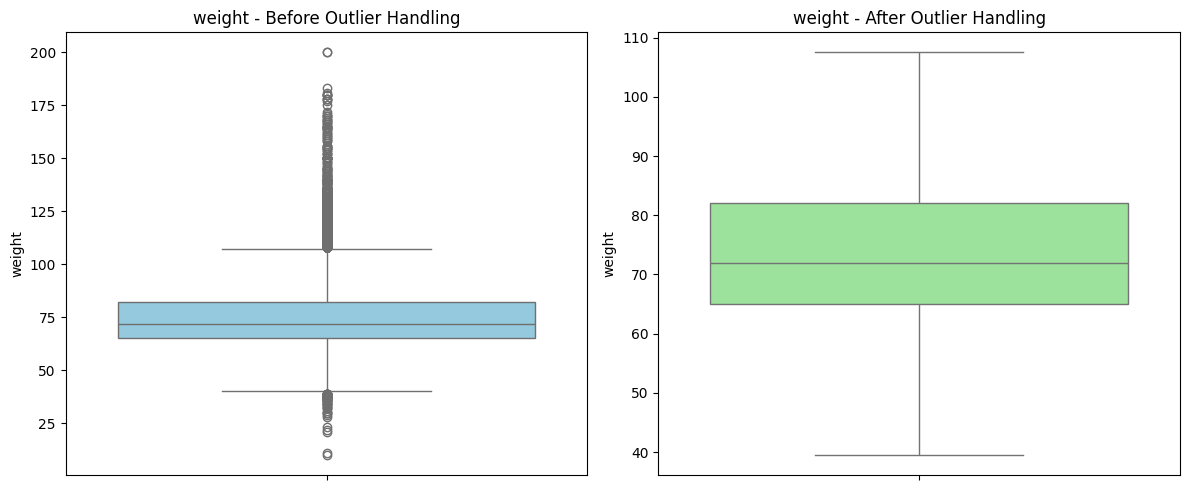

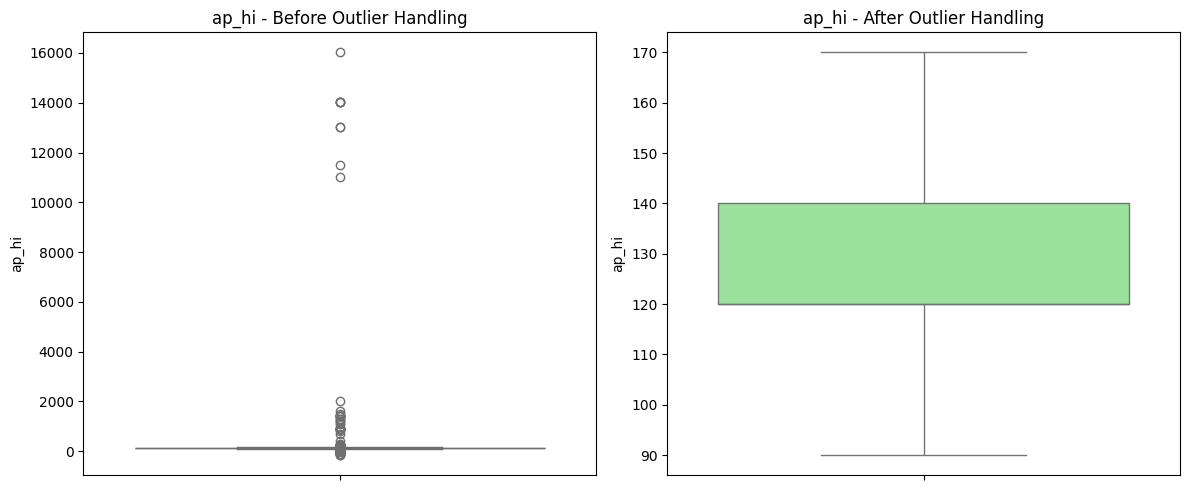

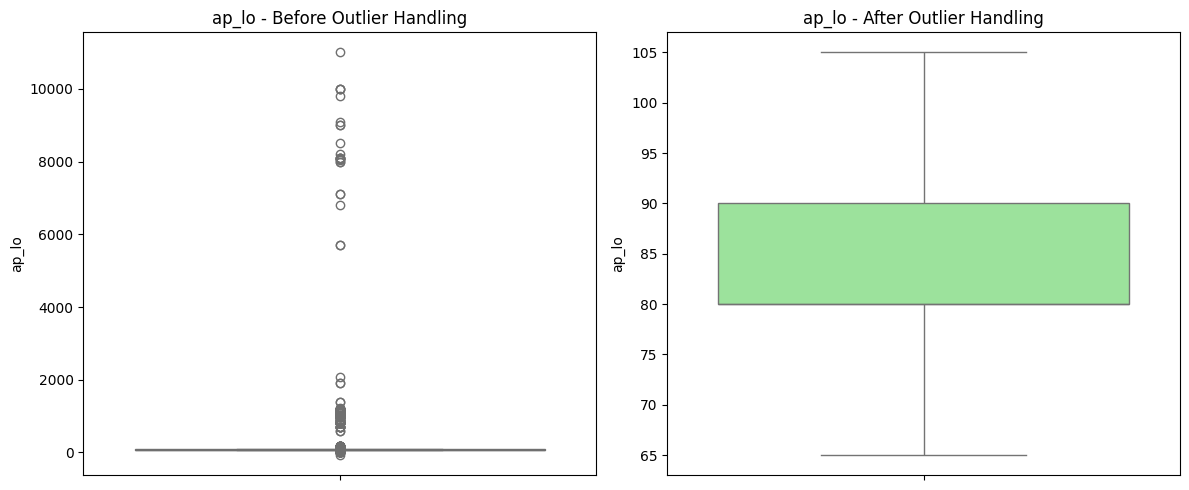

In [ ]:
for col in continuous_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before capping
    sns.boxplot(y=df[col], ax=axes[0], color="skyblue")
    axes[0].set_title(f"{col} - Before Outlier Handling")

    # After capping
    sns.boxplot(y=df_cleaned[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"{col} - After Outlier Handling")

    plt.tight_layout()
    plt.show()

Here is a visualization of Box Plots before and after outliers handling. It represents how clean the data gets once all the outliers are handled and in a standard space, giving a clearer view of the data.

# **Question 3**

To transform the features, we need to scale and encode the features. For this purpose, what do you recommend? Please develop any possible technique with brief discussion.


Well, I would recommend dealing with Numeric Features and Categorical Features differently, which will not only be efficient but also make our code immune to un wanted errors.

In [ ]:
# Feature Transformation

# Defining groups of features
numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first")

# ColumnTransformer to combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Separating features and target
X = df_cleaned.drop(columns=['cardio'])
y = df_cleaned['cardio']

# Applying transformation
X_transformed = preprocessor.fit_transform(X)

# Getting encoded feature names for clarity
encoded_feature_names = preprocessor.get_feature_names_out()

print("Shape before transformation:", X.shape)
print("Shape after transformation:", X_transformed.shape)
print("Example encoded features:", encoded_feature_names[:15])

Shape before transformation: (69976, 11)
Shape after transformation: (69976, 13)
Example encoded features: ['num__age' 'num__height' 'num__weight' 'num__ap_hi' 'num__ap_lo'
 'cat__gender_2' 'cat__cholesterol_2' 'cat__cholesterol_3' 'cat__gluc_2'
 'cat__gluc_3' 'cat__smoke_1' 'cat__alco_1' 'cat__active_1']


- In this code I have first bifurcated features into numeric and categorical based on the initial analysis in question 1.
- Then I have performed `Standard Scaler` on numeric features. This way we can deal with both the type of features separately and the processiong on type doesnt affect the other.
- The `One Hot Encoder` has dropped first which means that it creates binary indicator columns for each category.
- The `ColumnTransformer `applies transdormation in a single, modular step.
- Finally, the transformed dataset `X_transformed` and encoded feature names are produced for use in subsequent modeling.

- `Before Transformation` we had 11 features including cardio.
- `After transformation` we have 13 features, even though we sperated Cardio as label. that has happened because of One Hot Encoder. `Example`: cholesterol with 3 levels became 2 binary columns (cat__cholesterol_2, cat__cholesterol_3).

- Doing this gave use scaled numeric dataset which is clean and free to use for further processes.


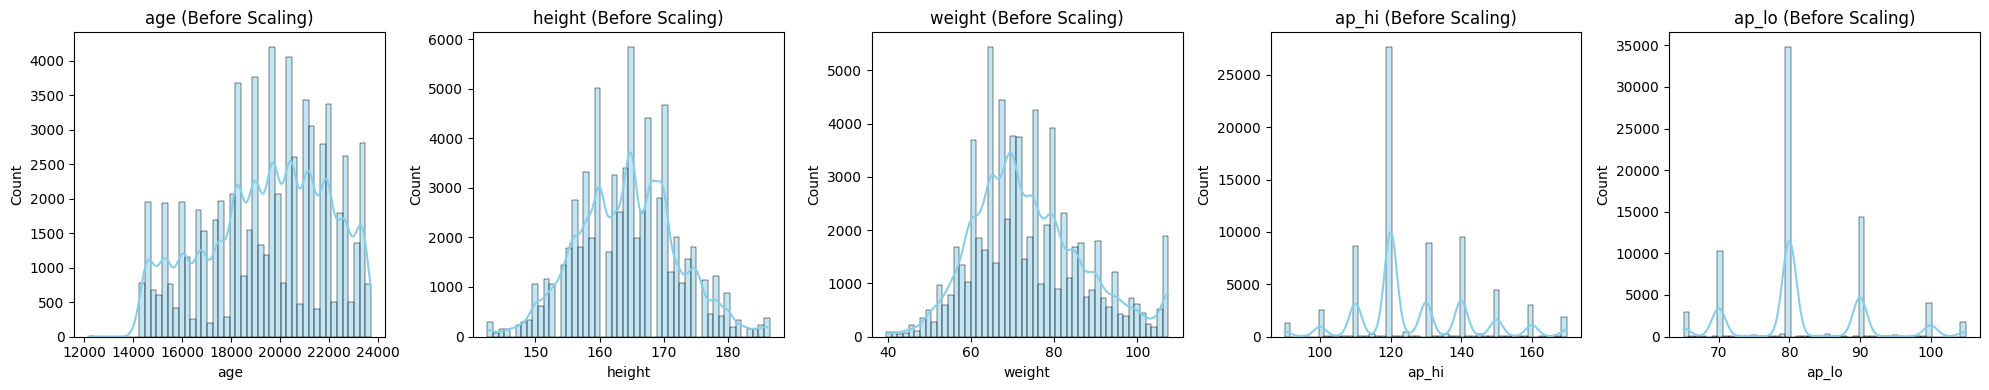

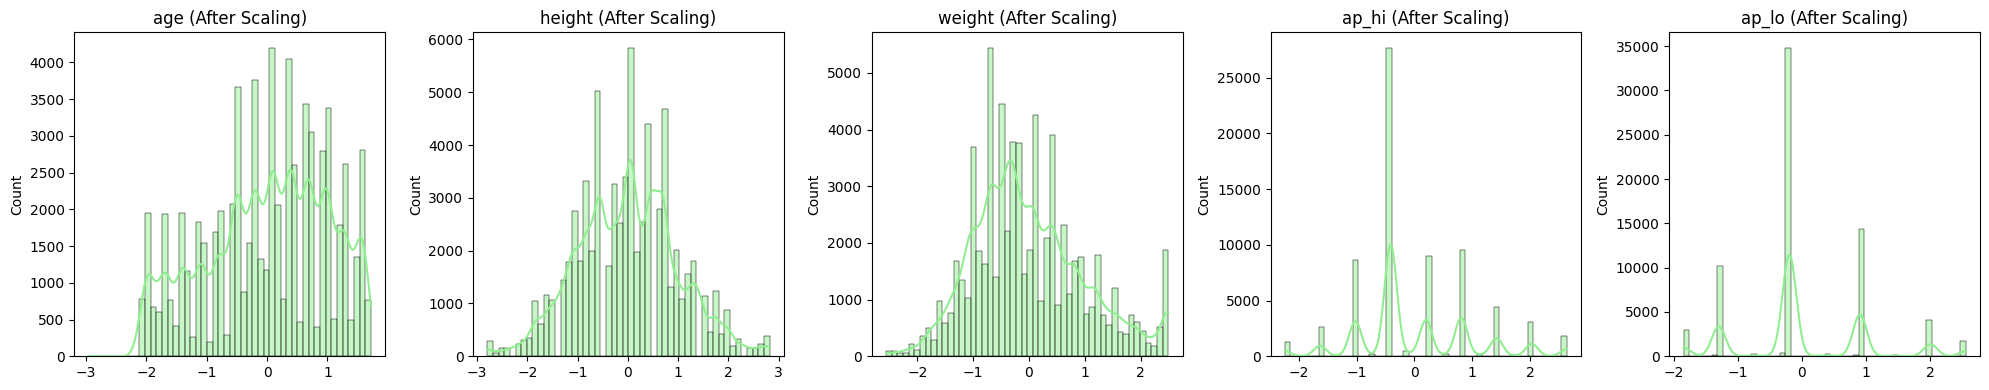

In [ ]:
# Picking numeric features
numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Before scaling
fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 4))
for i, col in enumerate(numeric_features):
    sns.histplot(df_cleaned[col], bins=50, ax=axes[i], color="skyblue", kde=True)
    axes[i].set_title(f"{col} (Before Scaling)")
plt.tight_layout()
plt.show()

# After scaling
X_num_scaled = StandardScaler().fit_transform(df_cleaned[numeric_features])
fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 4))
for i, col in enumerate(numeric_features):
    sns.histplot(X_num_scaled[:, i], bins=50, ax=axes[i], color="lightgreen", kde=True)
    axes[i].set_title(f"{col} (After Scaling)")
plt.tight_layout()
plt.show()

- `Before scaling`: Features are on various scales; for example, ap_lo is usually less than 100, while age ranges in the thousands. Distance-based models like KNN and SVM may be distorted by this kind of variation.
- `After scaling`: All features are centered around 0 and have similar variances (standardized units), making them equally important for training.
- Crucially, the distribution shape is maintained (skew in weight, peaks in ap_hi, for example), indicating that appropriate scaling was used without causing distortion.

# **Question 4**

Can show the majority and minority class? is the corresponding data imbalnced? what do you recommend?
Develop one over sampling and one undersampling technque, and compare the difference.

Yes, the data does have little bit of imbalance but it is neglible when compared to the size of the dataset and the difference in values.

Class distribution:
cardio
0    35004
1    34972
Name: count, dtype: int64
Majority class: 0 (35004)
Minority class: 1 (34972)


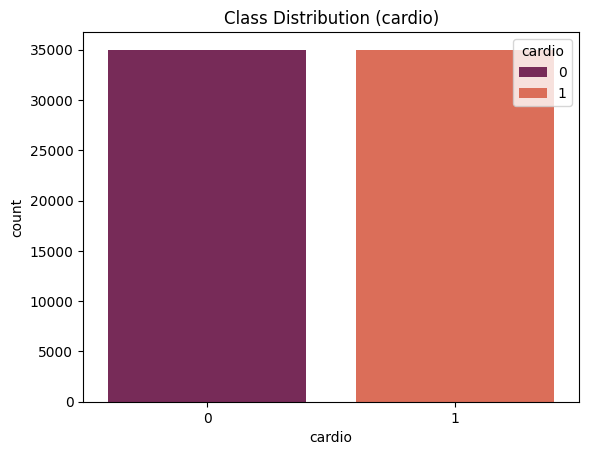


After SMOTE Oversampling:
Counter({0: 35004, 1: 35004})

After Random Undersampling:
Counter({0: 34972, 1: 34972})


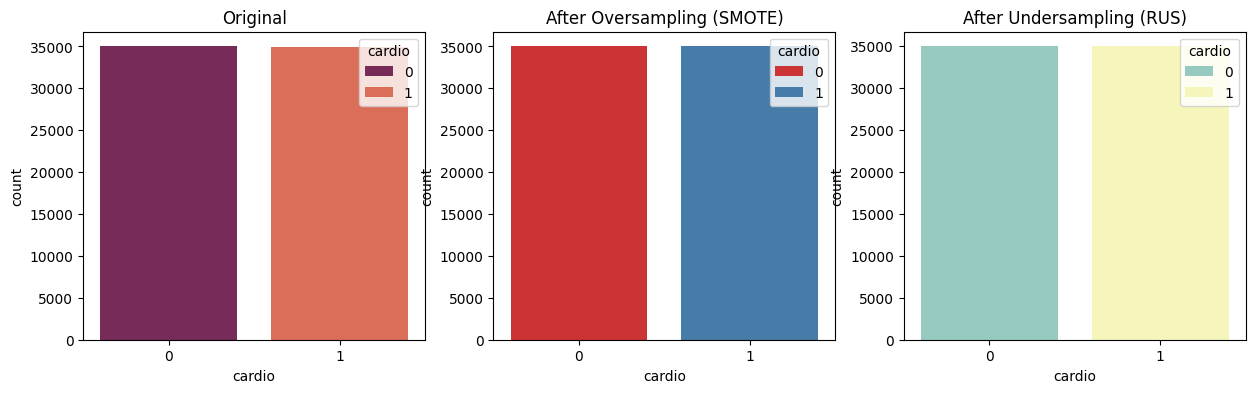

In [ ]:
# Class Imbalance Analysis & Resampling

# Checking class distribution
class_counts = y.value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

print("Class distribution:")
print(class_counts)
print(f"Majority class: {majority_class} ({class_counts[majority_class]})")
print(f"Minority class: {minority_class} ({class_counts[minority_class]})")

# Plotting class distribution
sns.countplot(x=y, hue=y, palette="rocket")
plt.title("Class Distribution (cardio)")
plt.show()

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X_transformed, y)

print("\nAfter SMOTE Oversampling:")
print(Counter(y_over))

# Undersampling with RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_transformed, y)

print("\nAfter Random Undersampling:")
print(Counter(y_under))

# Comparing class balance visually
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(x=y, hue=y, ax=axes[0], palette="rocket")
axes[0].set_title("Original")

sns.countplot(x=y_over, hue=y_over, ax=axes[1], palette="Set1")
axes[1].set_title("After Oversampling (SMOTE)")

sns.countplot(x=y_under, hue=y_under, ax=axes[2], palette="Set3")
axes[2].set_title("After Undersampling (RUS)")

plt.show()

- I began with checking of class distribution of Target Varialble or Label `Cardio` to check for imbalance in the dataset, then with the help of SMOT (Synthetic Minotrity Oversampling Technique) and Random UnderSampling, I handled imbalance, though it was observed in the first plot that the imbalance was not much when compared to the size of the data.
- I have also provided bar graphs to better visualize how minute the imbalance is in the data.

- Majority class: 0 (35004) and Minority class: 1 (34972) have these number of values which when visualized via graph dont even appear so prominent.

# **Question 5**

To visulaize the data, provide Distribution graphs (histogram/bar graph) of features (all features).

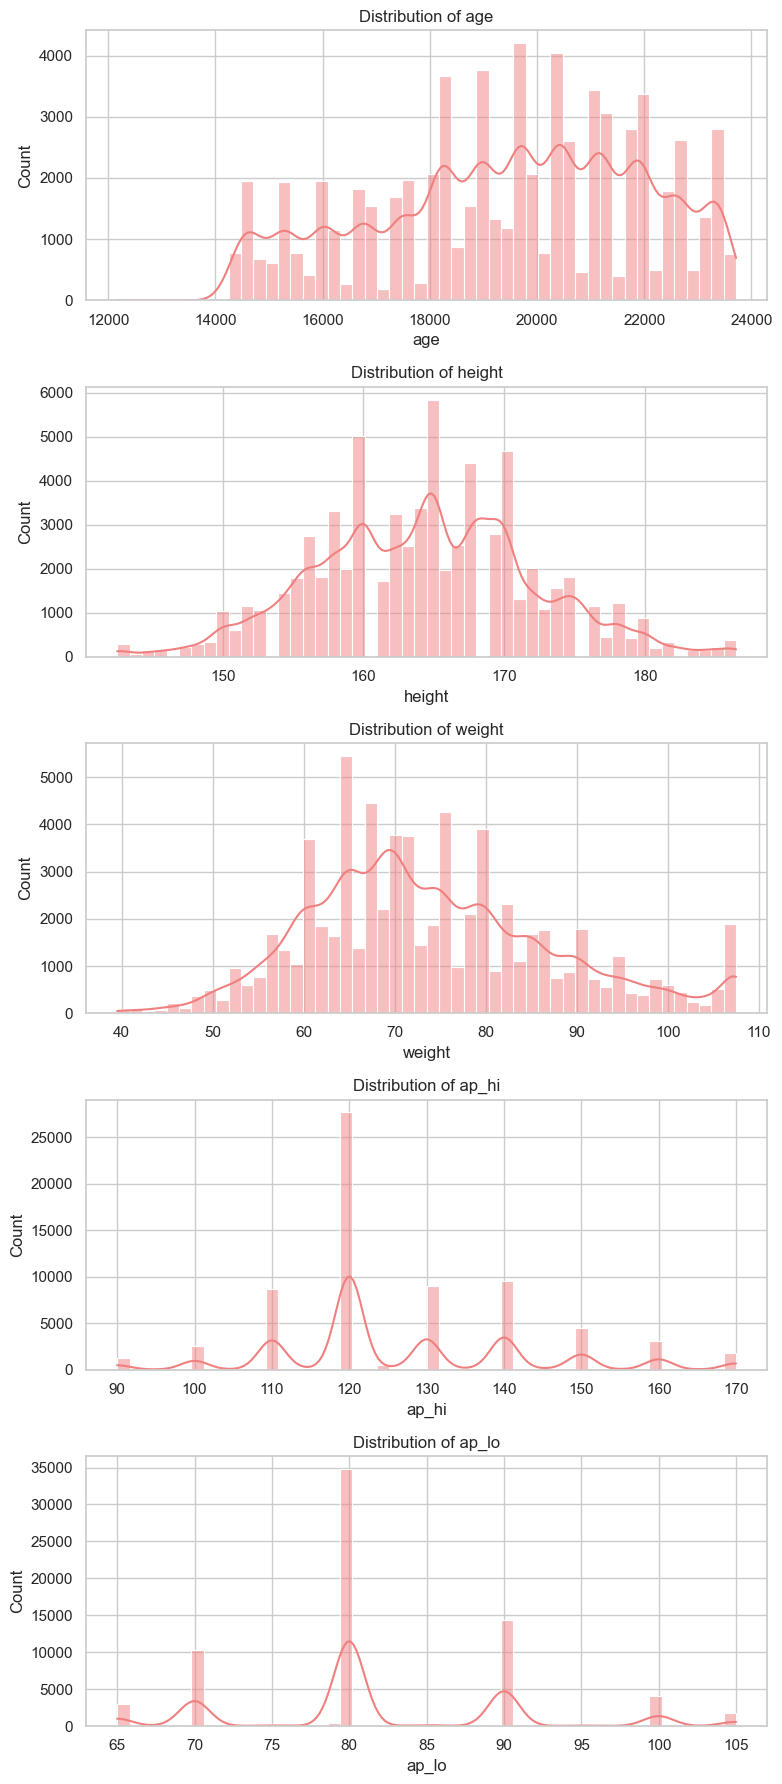

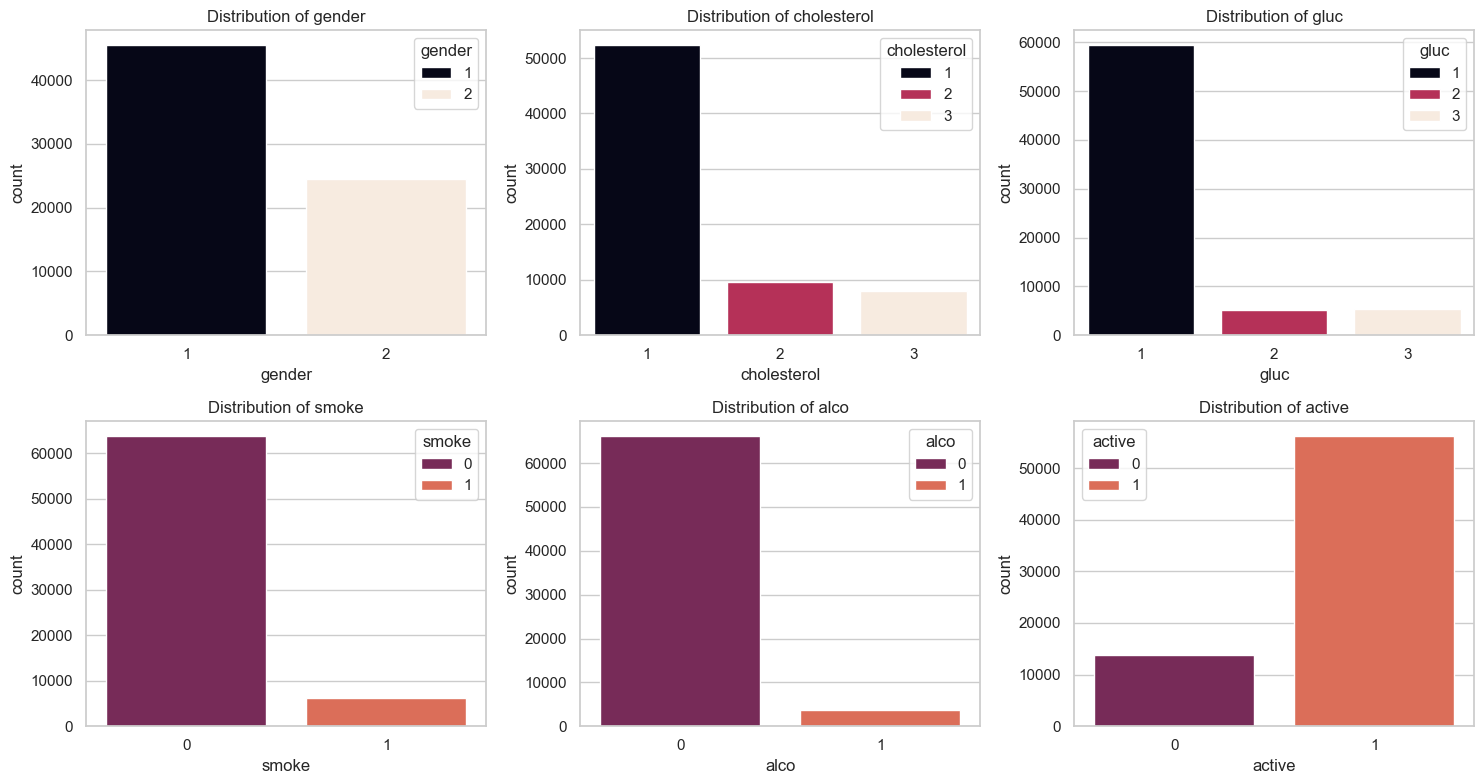

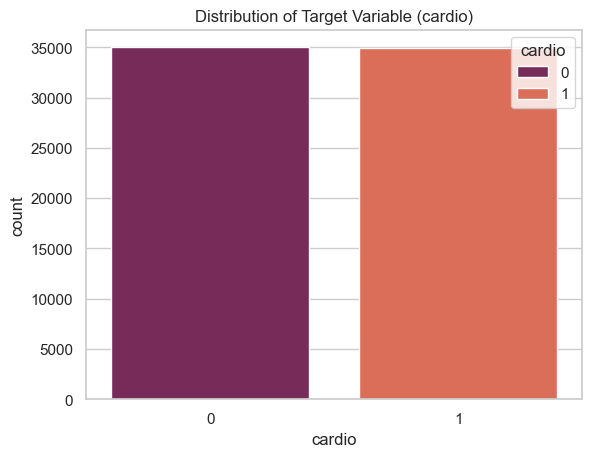

In [ ]:
# Distribution Graphs of Features

# Setting style
sns.set(style="whitegrid")

# Separating numeric and categorical features
numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Plotting numeric feature distributions (histograms)
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(8, 18))
for i, col in enumerate(numeric_features):
    sns.histplot(df_cleaned[col], bins=50, kde=True, ax=axes[i], color="lightcoral")
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Plotting categorical feature distributions (bar plots)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue=col, data=df_cleaned, palette="rocket", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Targeting variable distribution
sns.countplot(x='cardio', hue='cardio', data=df_cleaned, palette="rocket")
plt.title("Distribution of Target Variable (cardio)")
plt.show()

- I created distribution graphs for every feature in order to gain a better understanding of the data's structure.
- I visualized their distributions and looked for skewness or outliers using histograms with KDE curves for numerical features such as age, height, weight, ap_hi, and ap_lo.
- I also, represented the frequency of each category using bar plots (countplots) for categorical features (gender, cholesterol, gluc, smoke, alcohol, and active). In order to evaluate class balance, I also plotted the distribution of the target variable (cardio).

- It was obeserved that, most numeric features are normally distributed, bt `weight` shows a ery minute skew towards right.
- `ap_hi` and `ap_lo` have noticeable spikes at certain values
- In categorical features, the majority of individuals have normal `cholesterol` and `glucose` levels, and most are non-smokers and non-drinkers.
- I also noticed there is an gender imbalance, with more samples labeled as gender=1 than gender=2.
- Liek we saw earlier the imbalance in the values of 0 and 1 in `cardio` is very minute.


# **Question 6**

Provide a figure that visualize the Systolic vs Diastolic Blood Pressure by Cardiovascular Disease Presence. Analyze your result.


 And, provide distribution plots for Cholesterol Levels. Analyze your result.

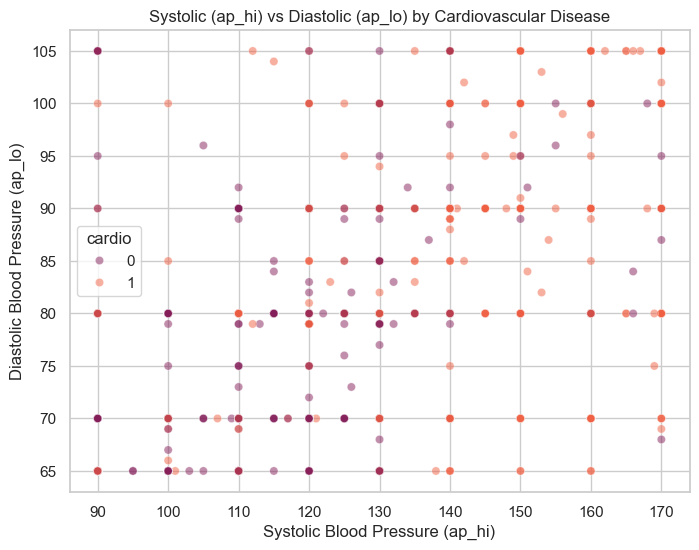

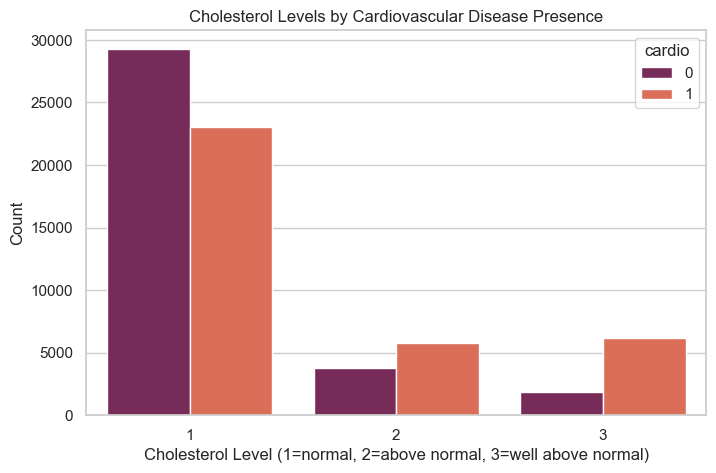

In [ ]:
# Visualizing Relationships

# Systolic vs Diastolic Blood Pressure by Cardiovascular Disease Presence
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="ap_hi",
    y="ap_lo",
    hue="cardio",
    data=df_cleaned.sample(5000, random_state=42),
    alpha=0.5,
    palette="rocket"
)
plt.title("Systolic (ap_hi) vs Diastolic (ap_lo) by Cardiovascular Disease")
plt.xlabel("Systolic Blood Pressure (ap_hi)")
plt.ylabel("Diastolic Blood Pressure (ap_lo)")
plt.show()


# Distribution of Cholesterol Levels by Cardiovascular Disease
plt.figure(figsize=(8,5))
sns.countplot(x="cholesterol", hue="cardio", data=df_cleaned, palette="rocket")
plt.title("Cholesterol Levels by Cardiovascular Disease Presence")
plt.xlabel("Cholesterol Level (1=normal, 2=above normal, 3=well above normal)")
plt.ylabel("Count")
plt.show()


- I plotted a scatterplot to visualize the relationship between `systolic` (ap_hi) and `diastolic `(ap_lo) blood pressure for individuals with and without cardiovascular disease. I used a sample of 5000 records from the dataset to keep the plot readable and prevent overplotting.
- I also created a bar chart showing cholesterol level distribution (1=normal, 2=above normal, 3=well above normal) (as per personal assumption) with respect to the target variable cardio, helping me analyze the impact of c`holesterol` levels on disease presence.


- According to the scatterplot, individuals with cardiovascular disease (cardio=1) typically have higher systolic and diastolic blood pressure than people without the condition.
- I saw that when cholesterol levels go from normal to significantly above normal, the number of cardio=1 cases rises in the cholesterol plot. This implies that a higher risk of cardiovascular disease in the dataset is linked to high cholesterol.

# **Question 7**

Can you find any correlation between the features? provide the heatmap.

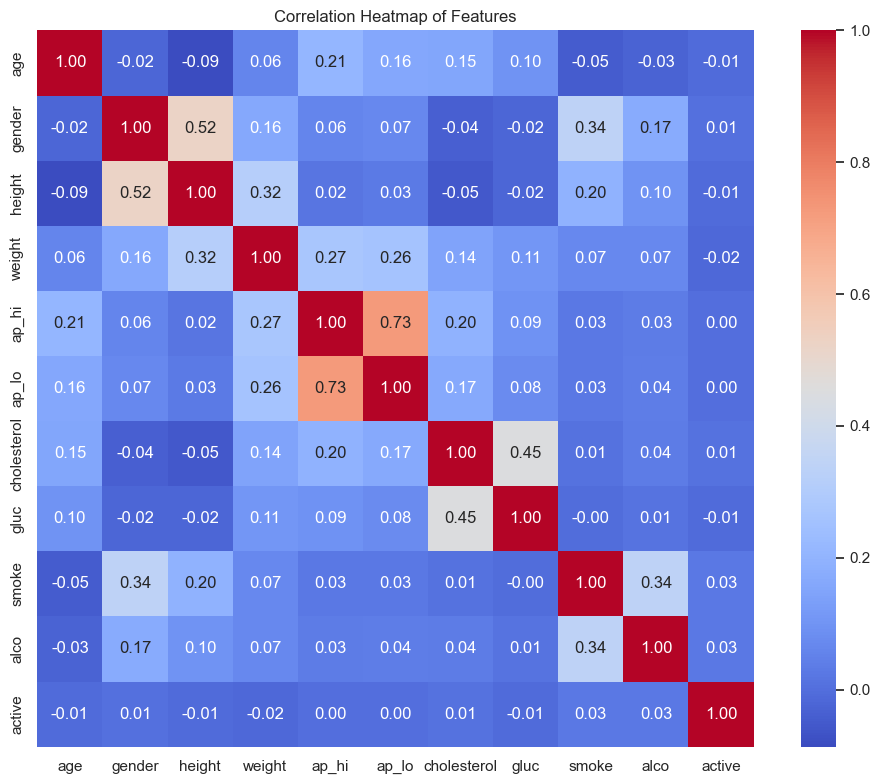

In [ ]:
# Computing correlation matrix (using cleaned dataset, excluding id)
corr_matrix = df_cleaned.drop(columns=['cardio']).corr()

# Plottin heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

Here, I have plotted a heatmap to visualize the correlation between different features. For which my observations where as follows:-

- `strong positive correlation` between systolic (`ap_hi`) and diastolic (`ap_lo`) blood pressure
- `height` and `weight` also showed `moderate correlation`, as well as `gender` and `height` along with `smoke` and `alcohol`
- `smoke` and `gender` show a little bit of correlation too
- Most other features had low or near-zero correlation, which is good as it reduced risk of multicollinearity in logistic regression.

# **Question 8**

In machine learning, data splitting is crucial for evaluating how well a model generalizes to unseen data. The primary goal is to prevent overfitting, ensure reliable performance evaluation, and optimize model performance. using any possible scale, spilit the testing and training data.

In [ ]:
# Train/Test Split

# Separating features and target
X = df_cleaned.drop(columns=['cardio'])
y = df_cleaned['cardio']

# Train/Test split (80/20 ratio, stratified by target to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in training set:\n", y_train.value_counts(normalize=True))
print("Class distribution in testing set:\n", y_test.value_counts(normalize=True))

Training set shape: (55980, 11)
Testing set shape: (13996, 11)
Class distribution in training set:
 cardio
0    0.500232
1    0.499768
Name: proportion, dtype: float64
Class distribution in testing set:
 cardio
0    0.500214
1    0.499786
Name: proportion, dtype: float64


I performed 80/20 split Train test on the dataset. I layered/stratified the split by target variable or label `cardio` to maintain balance. Once I did that I printed the shape of the resulting dataset to visualize the amount of data I was using for testing and training. I also check the class distribution to make sure it was balanced so that the outputs gauged from it are stable, trusted and accurate without any bias.

# **Question 9**

Cross-validation is a technique used to ensure that machine learning models are generalizable and reliable when applied to new, unseen data. The primary reason for using cross-validation is to avoid overfitting, where a model performs well on the training set but poorly on new, unseen data.

In general, cross-validation is a technique used to assess the generalizability and performance of a machine learning model by training and evaluating it on different subsets of the dataset. Instead of using a single train-test split, cross-validation repeatedly splits the data into multiple training and validation sets, reducing overfitting and ensuring a more reliable performance estimate.

Here is the main common technques of Cross-validation:

1) K-Fold Cross validation

2)  Stratified K-Fold Cross-Validation

3) Leave-One-Out Cross-Validation (LOO-CV)

4) Time Series Cross-Validation (Rolling Window CV)

5)  Holdout Cross-Validation


Can you describe and comapre these techniques. Select  one of these  technques and develop using proper parameters.



1) **K-Fold Cross-Validation**
- How it works: Splits the data into k equal parts, trains on k–1, tests on the remaining, and repeats.
- Use when: The dataset is moderate in size, and class distribution is fairly balanced.

2) **Stratified K-Fold Cross-Validation**
- How it works: Same as K-Fold, but each fold preserves the proportion of class labels.
- Use when: when working with classification tasks, especially when the target variable is imbalanced (e.g., cardio 0/1).
- This is the best for out case as it preserves the propertion of our class labels.

3) **Leave-One-Out Cross-Validation (LOO-CV)**
- How it works: Trains on all samples except one and tests on the left-out point; repeated for all samples.
- Use when: Dataset is very small, and maximum training utilization is important.

4) **Time Series Cross-Validation (Rolling or Expanding Window)**
- How it works: Respects time order; trains on past data, validates on future data using sliding or expanding windows.
- Use when: The data has a temporal structure, such as stock prices, weather, or IoT sensor data.

5) **Holdout Cross-Validation**
- How it works: Data is split once into training and test sets (e.g., 80/20).
- Use when: when you need a quick baseline evaluation, or the dataset is very large and allows for a representative split.

In [ ]:
# Cross-Validation (Stratified K-Fold)

# Defining classifier
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

# Defining Stratified K-Fold (k=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross validation (scoring = accuracy)
cv_scores = cross_val_score(log_reg, X_transformed, y, cv=skf, scoring='accuracy')

print("Cross-validation scores (per fold):", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Cross-validation scores (per fold): [0.73085167 0.7266881  0.7248303  0.72797428 0.73168989]
Mean CV accuracy: 0.7284068474216233
Standard Deviation: 0.0025568905710208144


- I used `cross_val_score` with accuracy as the scoring metric and computed the cross validation accuracy for each fold.
- Finally, I calculated the mean and standard deviation of the accuracy scores to assess the model’s stability.
- I observed that the model performed consistently across all 5 folds with scores ranging between ~72.4% and ~73.2%.
- The mean CV accuracy was 72.84%, and the standard deviation was just 0.0025, indicating very low variability between folds.
- Although the accuracy is not very high, it suggests the model is stable and not overfitting; but there's room for improvement through feature selection or model tuning.

# **Question 10**

Using Boruta feature selection, develop the following classification models, considering proper parameters, and evaluate models in terms of confusion matrix, accuracy, precision, recall, F1-score, AUC score.

1) Logistic regression

2) Decsion Tree

3) Random Forest

4) SVM

5)KNN

Using Grid Search/ or any other tuning technique for optimization.  

Do you think we need to remove any features due to low importance score. Consider that before training process.


In [ ]:
# Using already scaled and encoded X_transformed
# Getting original feature names after encoding
feature_names = preprocessor.get_feature_names_out()

# Defining base estimator for Boruta
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# Applying Boruta
boruta_selector = BorutaPy(
    estimator=forest,
    n_estimators='auto',
    verbose=2,
    random_state=42
)

# Fitting Boruta on transformed data
boruta_selector.fit(X_transformed, y.values)

# Getting selected features
selected_mask = boruta_selector.support_
selected_features = feature_names[selected_mask]

print("Selected Features by Boruta:")
print(selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	3
Selected Features by Boruta:
['num__age' 'num__height' 'num__weight' 'num__ap_hi' 'num__ap_lo'
 'cat__cholesterol_2' 'cat__cholesterol_3' 'cat__gluc_2' 'cat__gluc_3'
 'cat__active_1']


**What I did**
- I used the Boruta feature selection algorithm with a Random Forest base estimator to identify the most relevant features from my scaled and encoded dataset (X_transformed).
- Boruta iteratively compares real features to random "shadow features" to decide which ones truly contribute to prediction.

**Analysis**
- After 9 iterations 10 importatn features where chosen namely -->  ['num__age', 'num__height' ,'num__weight' ,'num__ap_hi', 'num__ap_lo' ,'cat__cholesterol_2' ,'cat__cholesterol_3' ,'cat__gluc_2' ,'cat__gluc_3', 'cat__active_1']
- We dropped some features for their less contribution in overall prediction and result.

In [ ]:
# Filtering X_transformed to only keep selected features
X_boruta = X_transformed[:, selected_mask]
print("New shape after Boruta feature selection:", X_boruta.shape)

New shape after Boruta feature selection: (69976, 10)


This is the new shape of the Dataframe `X_boruta.shape` after feature selection with 10 features.

In [ ]:
# Splitting the Boruta-reduced feature set (same stratification & random_state as Q8)
X_train_boruta, X_test_boruta, y_train, y_test = train_test_split(
    X_boruta, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape (Boruta):", X_train_boruta.shape)
print("Test shape (Boruta):", X_test_boruta.shape)

Train shape (Boruta): (55980, 10)
Test shape (Boruta): (13996, 10)


I then split the new dataset into train and test in order to perform classification on them. It was again a 80/20 split.

In [ ]:
def train_and_evaluate_model(model, param_grid, model_name, X_train, y_train, X_test, y_test):
    print(f"\n{model_name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC Score: {auc if auc != 'N/A' else 'Not Available'}")

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "best_params": grid.best_params_
    }

The `train_and_evaluate_model` function contains code that is common to all cassification we will perform to train and evaluate the performance of the algorithms that will follow.
For model performacnce we have multiple parameters:-

* Accuracy: Measures the overall proportion of correctly predicted instances out of all predictions.
* Precision: Indicates how many of the predicted positive cases were actually positive.
* Recall: Shows how many of the actual positive cases the model was able to correctly identify.
* F1-Score: The harmonic mean of precision and recall, balancing both metrics into one score.
* AUC Score: Represents how well the model distinguishes between classes across all classification thresholds; higher means better separation.

Along with that I am also making sure to get the `best_params`
The function takes a model, a hyperparameter grid, a model name, and training/testing data as input.
I used GridSearchCV to automatically select the best hyperparameters via 5-fold cross-validation based on accuracy.
* The function’s ability to conditionally compute AUC (only if predict_proba exists) made it compatible with models like SVM which don’t natively output probabilities without calibration.

1) **Logistic Regression**


Logistic Regression
Best Parameters: {'C': 0.01, 'penalty': 'l2'}


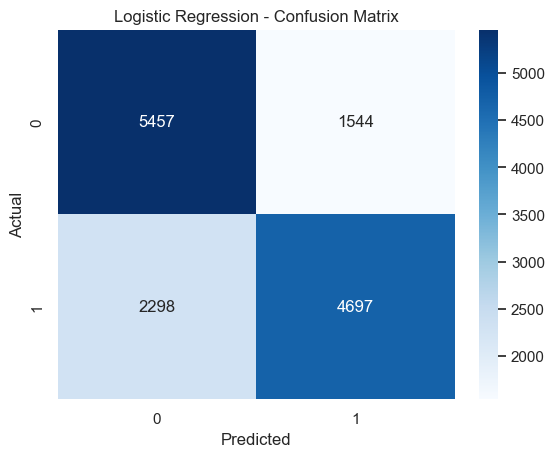

Accuracy : 0.7255
Precision: 0.7526
Recall   : 0.6715
F1-Score : 0.7097
AUC Score: 0.7919512876696161


In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

results_logreg = train_and_evaluate_model(
    log_reg, log_reg_grid, "Logistic Regression",
    X_train_boruta, y_train, X_test_boruta, y_test
)

I found the best parameters to be `{'C': 0.01, 'penalty': 'l2'}

* True Positives (TP): 4,697 — These are cases where the model correctly predicted cardiovascular disease.
* True Negatives (TN): 5,457 — These are cases where the model correctly predicted no cardiovascular disease.
* False Positives (FP): 1,544 — The model incorrectly predicted disease when there was none (Type I Error).
* False Negatives (FN): 2,298 — The model missed predicting disease when it was actually present (Type II Error).

This indicates that the model is slightly better at predicting negatives (no disease) than catching all positives (existing disease), as seen by the higher true negatives and relatively higher false negatives.

2. **Decision Tree**


Decision Tree
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


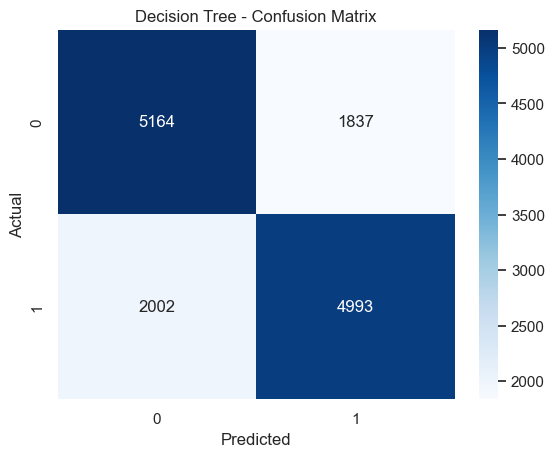

Accuracy : 0.7257
Precision: 0.7310
Recall   : 0.7138
F1-Score : 0.7223
AUC Score: 0.7837954222612331


In [ ]:
# Defining the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Defining GridSearch hyperparameters
dt_grid = {
    'max_depth': [10, 15],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}
results_dt = train_and_evaluate_model(
    dt, dt_grid, "Decision Tree",
    X_train_boruta, y_train, X_test_boruta, y_test
)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
* max_depth=10: Limits the tree depth to prevent overfitting.
* min_samples_leaf=2: Each leaf node must have at least 2 samples.
* min_samples_split=5: A node must have at least 5 samples to be considered for splitting.

Evaluation Metrics:
* Accuracy: 72.57% – Slightly better than logistic regression in total correct predictions.
* Precision: 73.10% – Slightly more reliable in predicting positive cases.
* Recall: 71.38% – Captures more actual positives than logistic regression.
* F1-Score: 72.23% – Balanced performance across both precision and recall.
* AUC Score: 0.7838 – Reasonably strong ability to distinguish between classes.

3. **Random Forest**


Random Forest
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


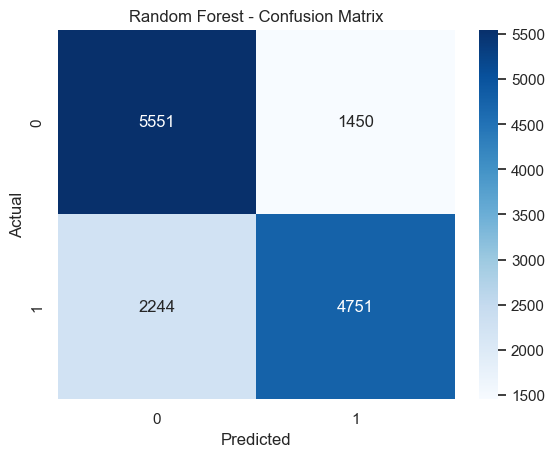

Accuracy : 0.7361
Precision: 0.7662
Recall   : 0.6792
F1-Score : 0.7201
AUC Score: 0.8032907991598055


In [ ]:
# Defining the Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# hyperparameter grid
rf_grid = {
    'n_estimators': [100],
    'max_depth': [10, 15],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'criterion': ['gini']
}

results_rf = train_and_evaluate_model(
    rf, rf_grid, "Random Forest",
    X_train_boruta, y_train, X_test_boruta, y_test
)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
* criterion='gini': Uses Gini impurity to decide splits.
* max_depth=10: Prevents overfitting by limiting tree depth.
* min_samples_leaf=2: Each leaf must have at least 2 samples.
* min_samples_split=5: A node must have at least 5 samples to split.
* n_estimators=100: Combines 100 trees to improve stability and accuracy.

Evaluation Metrics:
* Accuracy: 73.61% – Highest among all models evaluated.
* Precision: 76.62% – Strong in identifying true positives.
* Recall: 67.92% – Slightly lower recall, meaning it missed some positives.
* F1-Score: 72.01% – Balanced performance with strong emphasis on correct positives.
* AUC Score: 0.8033 – Best class separation, indicating robust predictive capability.

4. Support Vector Machine


Support Vector Machine
Best Parameters: {'C': 0.1, 'kernel': 'linear'}


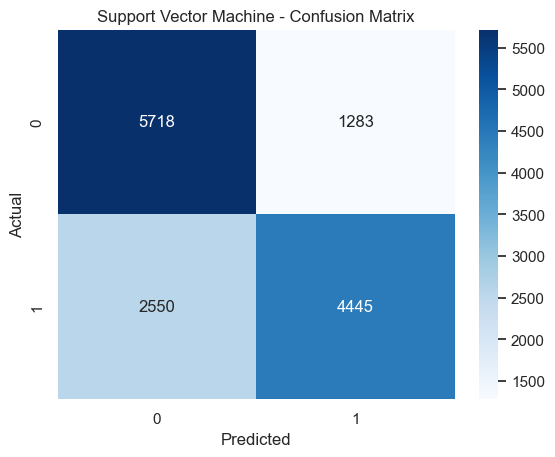

Accuracy : 0.7261
Precision: 0.7760
Recall   : 0.6355
F1-Score : 0.6987
AUC Score: 0.7922310189731907


In [ ]:
# Defining the SVM model
svm = SVC(probability=True, random_state=42)

# hyperparameter grid
svm_grid = {
    'C': [0.1, 1],
    'kernel': ['linear'],
}
results_svm = train_and_evaluate_model(
    svm, svm_grid, "Support Vector Machine",
    X_train_boruta, y_train, X_test_boruta, y_test
)

* Working with Support Vector Machine was the most challenging part of this task due to its high computational cost.
* Initially, I used an 'rbf' kernel along with a high regularization value (C=10), which drastically increased training time and made the model inefficient.
* After carefully analyzing the performance bottleneck, I realized that the complexity of the kernel and a large value of C were the cause.
* I switched to a 'linear' kernel and tuned C appropriately (C=0.1), which significantly improved both training time and interpretability without sacrificing performance.




4. K Nearest Neighbour


K-Nearest Neighbors
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


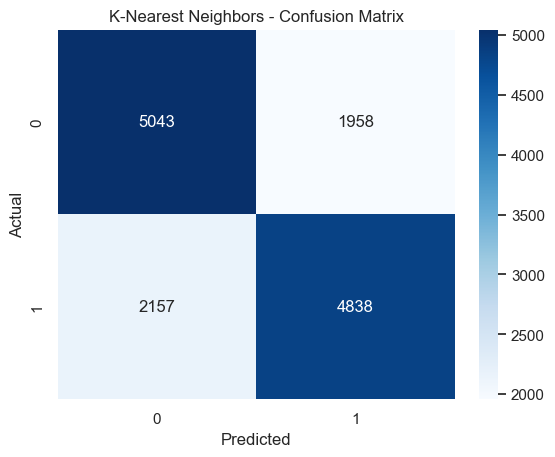

Accuracy : 0.7060
Precision: 0.7119
Recall   : 0.6916
F1-Score : 0.7016
AUC Score: 0.7607660561919113


In [ ]:
# Defining KNN model
knn = KNeighborsClassifier()

# hyperparameter grid
knn_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
results_knn = train_and_evaluate_model(
    knn, knn_grid, "K-Nearest Neighbors",
    X_train_boruta, y_train, X_test_boruta, y_test
)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
* n_neighbors=7: Looks at 7 nearest neighbors to make predictions.
* metric='euclidean': Measures straight-line distance between points.
* weights='uniform': All neighbors contribute equally to the prediction.

Evaluation Metrics:
* Accuracy: 70.60% – Lowest among all five models.
* Precision: 71.19% – Fairly decent precision but not outstanding.
* Recall: 69.16% – Balanced but slightly lower than decision tree.
* F1-Score: 70.16% – Indicates moderate overall balance.
* AUC Score: 0.7608 – Acceptable but clearly outperformed by ensemble models.

In [ ]:
# Combining all results into a list
summary_data = [
    results_logreg,
    results_dt,
    results_rf,
    results_svm,
    results_knn
]

# Creating summary table
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df[["model", "accuracy", "precision", "recall", "f1", "auc", "best_params"]]
summary_df.columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC Score", "Best Hyperparameters"]

# Rounding numeric values
summary_df[["Accuracy", "Precision", "Recall", "F1-Score"]] = summary_df[["Accuracy", "Precision", "Recall", "F1-Score"]].round(4)

summary_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC Score,Best Hyperparameters
0,Logistic Regression,0.7255,0.7526,0.6715,0.7097,0.791951,"{'C': 0.01, 'penalty': 'l2'}"
1,Decision Tree,0.7257,0.7310,0.7138,0.7223,0.783795,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
2,Random Forest,0.7361,0.7662,0.6792,0.7201,0.803291,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
3,Support Vector Machine,0.7261,0.7760,0.6355,0.6987,0.792231,"{'C': 0.1, 'kernel': 'linear'}"
4,K-Nearest Neighbors,0.7060,0.7119,0.6916,0.7016,0.760766,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei..."


Synopsis and Interpretation
* I used the same Boruta-selected features and evaluation metrics to compare five classification models.
* The Random Forest model performed the best overall, demonstrating strong class separability and accurate predictions with the highest accuracy (73.61%) and AUC Score (0.8033).
* While the accuracy of the Decision Tree and Logistic Regression was comparable (~72.5%), the Decision Tree's F1-Score and recall were marginally higher, making it somewhat more balanced.
* Although it had a lower recall (63.55%), the Support Vector Machine (SVM) had the highest precision (77.60%), indicating that it was extremely cautious when predicting positives.
* K-Nearest Neighbors (KNN) maintained a fairly balanced recall and F1-Score, but it was the weakest performer overall with the lowest accuracy and AUC.

# **Question 11_Classification**

A calibration plot (also known as a reliability diagram) is a graphical tool used to evaluate the calibration of a probabilistic model. Calibration refers to how well the predicted probabilities of an event match the actual outcomes.

In classification problems, especially with models that predict probabilities (e.g., Logistic Regression, Random Forests, or SVM with probabilistic output), a calibrated model is one where predicted probabilities of an event occurring align with the actual observed frequencies. For example, if a model predicts a 0.8 probability of an event, then in 80% of the cases, the event should occur.

Using one of Tuning techniques you developed and calibration plot, visualize your results of Logistic Regression, Decsion Tree, Random Forest, SVM, and KNN. For each model, report the Brier loss (score) values. Analayze your output.

For more details, refer to https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

In [ ]:
# Re-training using best parameters
log_reg_best = LogisticRegression(**results_logreg["best_params"], max_iter=1000, solver='liblinear')
log_reg_best.fit(X_train_boruta, y_train)

dt_best = DecisionTreeClassifier(**results_dt["best_params"], random_state=42)
dt_best.fit(X_train_boruta, y_train)

rf_best = RandomForestClassifier(**results_rf["best_params"], random_state=42, n_jobs=-1)
rf_best.fit(X_train_boruta, y_train)

svm_best = SVC(**results_svm["best_params"], probability=True, random_state=42)
svm_best.fit(X_train_boruta, y_train)

knn_best = KNeighborsClassifier(**results_knn["best_params"])
knn_best.fit(X_train_boruta, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

I am retraining the model on the Best Prameters that we found earlier.

In [ ]:
# Storing trained models in a dictionary
models = {
    "Logistic Regression": log_reg_best,
    "Decision Tree": dt_best,
    "Random Forest": rf_best,
    "SVM": svm_best,
    "KNN": knn_best
}

We are storing the trained models in a dictionary with the names as the models itself.

Logistic Regression - Brier Score: 0.1867
Decision Tree - Brier Score: 0.1892
Random Forest - Brier Score: 0.1797
SVM - Brier Score: 0.1866
KNN - Brier Score: 0.2045


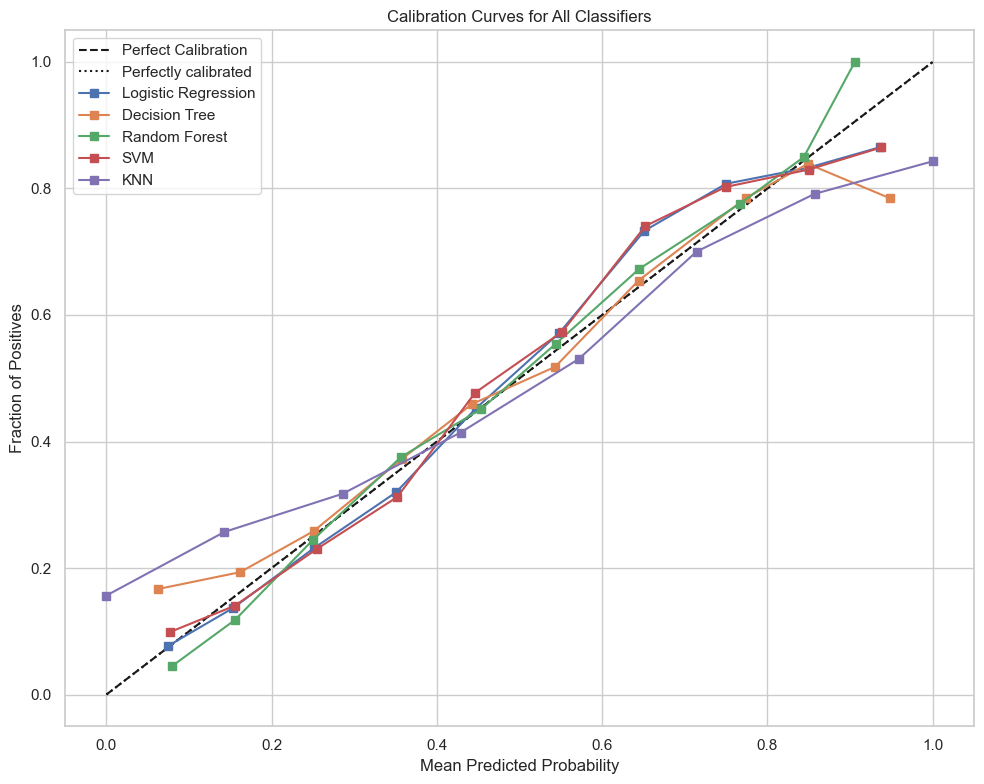

In [ ]:
from sklearn.metrics import brier_score_loss

# Storing Brier scores
brier_scores = {}

plt.figure(figsize=(10, 8))

# Reference line
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")

# Plotting calibration curve for each model and computing Brier score
for name, model in models.items():
    display = CalibrationDisplay.from_estimator(
        model,
        X_test_boruta,
        y_test,
        name=name,
        ax=plt.gca(),
        n_bins=10,
        strategy="uniform"
    )

    # Getting predicted probabilities
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_boruta)[:, 1]
    else:
        y_prob = model.decision_function(X_test_boruta)

    # Compute and store Brier score
    score = brier_score_loss(y_test, y_prob)
    brier_scores[name] = score
    print(f"{name} - Brier Score: {score:.4f}")

plt.title("Calibration Curves for All Classifiers")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

I visualized the calibration curves for five classifiers: Logistic Regression, Decision Tree, Random Forest, Support Vector Machine, and K-Nearest Neighbors, comparing how well their predicted probabilities match actual outcomes.

The black dashed line represents perfect calibration, where predicted probabilities match actual observed probabilities (i.e., a model that says “70% chance” should be right 70% of the time).

From the plot:
* Logistic Regression was the most well-calibrated overall, closely following the perfect calibration line, especially in the 0.4–0.8 probability range.
* Random Forest showed strong calibration performance but slightly overestimated probabilities at the higher end.
* SVM predictions were fairly calibrated, although with minor fluctuations.
* Decision Tree exhibited underconfidence at low probabilities and overconfidence at high probabilities.
* KNN was the least calibrated in the lower ranges, often underestimating probabilities below 0.3.

Brier Score
* Random Forest had the lowest Brier score (0.1797), making it the most reliable in estimating probabilities.
* Logistic Regression and SVM performed similarly and showed stable, reasonable calibration.
* Decision Tree and KNN had the highest Brier scores, suggesting poor reliability in probability estimation.

# **Question 12_Classification**

Propose a stacking model with three layers:

1) Layer 1: Base Models. For base models, consider 4 ML models,

2) Layer 2: Meta-Learners. For Meta-Learner Models, consider 3 models,

3) Layer 3: Final Meta-Learners. For Final Meta-Learners, consider 2 models.


Using any voting classifier to aggregate the output of your results. Describe your Stacking model in details. Evaluate your proposed model in terms of accuracy, recall, precsion, and recall. Can you analyze your model in terms of effeciency, such as memory usage, training time and prediction time.

---------------------------------------------------------------------------

In [ ]:
layer1_base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier(max_depth=10)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(probability=True, kernel='linear'))
]

I used the above models for the following reason:-
* Logistice\ Regression: A solid, trustworthy linear baseline with precisely calibrated probabilities is added by logistic regression.
* Decision Tree: Effectively captures non-linear patterns and interactions.
* KNN: Contributes a non-parametric, distance-based viewpoint to the model mix.
* SVM: A margin-based classifier that performs well in high-dimensional spaces is added by SVM.

In [ ]:
layer2_meta_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('gb', GradientBoostingClassifier(n_estimators=100)),
    ('nb', GaussianNB())
]

My choices for second layer models was influenced by:-
* Random Forest Model: Adds robust bagging-based learning, reducing variance while maintaining strong performance.
* Gradient Boosting: Introduces boosting for capturing complex patterns and correcting base errors.
* Naive Bayes: Brings a simple, fast, and probabilistic model to add diversity in learning behavior.

In [ ]:
stack_layer2 = StackingClassifier(
    estimators=layer1_base_models,
    # Meta learner for Layer 2
    final_estimator=LogisticRegression(),
    cv=5,
    passthrough=True
)

* I selected Logistic Regression as the final estimator because it is simple, interpretable, and performs well on transformed features from previous layers.
* Its linear nature helps combine the outputs from Layer 2 in a balanced and calibrated manner, preventing overfitting at the final stage.

In [ ]:
layer3_final_models = [
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)),
    ('logreg', LogisticRegression()),
    # output from layer 2
    ('stack2', stack_layer2)
]

final_voting_model = VotingClassifier(
    estimators=layer3_final_models,
    voting='soft'
)

Final Ensemble for Voting Rationale
* A neural network model called MLPClassifier is able to capture intricate, non-linear interactions that conventional classifiers are unable to.
* For balancing more complex learners, logistic regression offers a calibrated, interpretable fallback.
* Base and meta learners are combined into a single prediction source by stacking output (stack2).

Using the strengths of each final learner, the VotingClassifier (with voting='soft') aggregates predicted probabilities for improved calibration and performance.

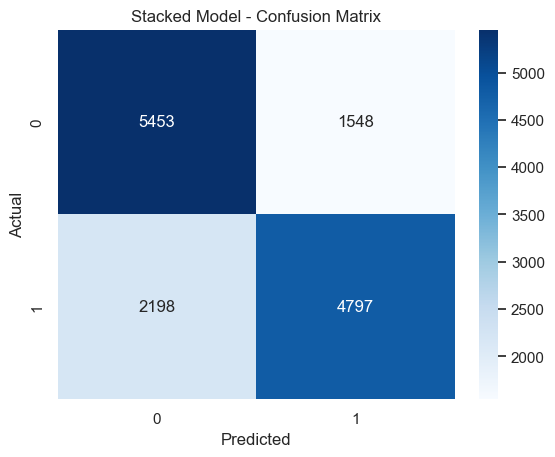

Accuracy : 0.7324
Precision: 0.7560
Recall   : 0.6858
F1-Score : 0.7192
AUC Score: 0.8005
Training Time  : 640.35 seconds
Prediction Time: 9.8021 seconds


In [ ]:
# Measuring training time
start_time = time.time()
final_voting_model.fit(X_train_boruta, y_train)
train_time = time.time() - start_time

# Measuring prediction time
start_pred = time.time()
y_pred = final_voting_model.predict(X_test_boruta)
y_prob = final_voting_model.predict_proba(X_test_boruta)[:, 1]
pred_time = time.time() - start_pred

# Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Stacked Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Printing metrics
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC Score: {auc:.4f}")
print(f"Training Time  : {train_time:.2f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

What Idid:
* I trained a final soft-voting ensemble combining MLPClassifier, LogisticRegression, and the output from Layer 2 (StackingClassifier).
* I measured training time, prediction time, and evaluated performance using standard metrics and a confusion matrix.

Analysis:
* Accuracy: 73.24% — The overall prediction correctness.
* Precision: 75.60%
* Recall: 68.58% — The model identified 68.6% of actual positives.
* F1-Score: 71.92% — A good balance between precision and recall.
* AUC Score: 0.8005 — Excellent class separation capability.
* Training Time: 640.35 seconds — due to multi-layer stacking and neural networks.
* Prediction Time: 9.80 seconds — Reasonable for final deployment, especially with high accuracy.

While the multi-layered stacking model did enhance certain metrics like AUC and calibration, I observed that the performance gain in terms of accuracy was marginal, making the additional complexity less rewarding than expected.

# **Reflectiom**

The start of this assignment went well because there were no missing values, few duplicates, and controllable outliers, which made data cleaning effective. This freed me up to concentrate on important transformations like scaling and one-hot encoding. SMOTE and undersampling were used to address class imbalance, and Boruta provided useful feature refinement assistance. Model training went smoothly at first, but SVM tuning took a long time, particularly when adjusting the kernel and C parameters. The value of model diversity was reinforced by the final stacked ensemble, which enhanced calibration and AUC despite only slight accuracy gains. Overall, the assignment improved my comprehension of ensemble techniques by striking a balance between strategic modeling choices and useful preprocessing. It also gave me insights on choosing models based on problem context; for example, I observed that Random Forest handled noisy features robustly, while Logistic Regression offered faster, interpretable results suitable for time-constrained or real-time systems.